# Predicting Player Newsletter Subscription Using Gaming Behavior

**DSCI 100 Group Project Report**

## Introduction

Video gaming has become one of the most popular forms of entertainment worldwide, with millions of players engaging across various platforms and genres. For game developers and publishers, understanding player engagement is crucial for building lasting relationships with their audience. One key metric of player engagement is newsletter subscription, which indicates a player's interest in staying connected with the game community and receiving updates.

In this analysis, we aim to answer the following research question:

> **What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**

Our specific research question is: **can factors such as `Age` and `played_hours` predict newsletter subscription in the `players` dataset?**

This question is significant because understanding subscription behavior can help game developers:
- Target marketing efforts more effectively
- Identify engaged players for community building
- Improve player retention strategies
- Personalize communication with different player segments

### Dataset Description

This project uses the dataset `players.csv` which contains information about individual players. The data was collected by the research group at [PlaiCraft.ai](https://plaicraft.ai).

| Variable Name  | Type      | Description                                     |
| -------------- | --------- | ----------------------------------------------- |
| `hashedEmail`  | Character | Unique identifier for each player (anonymized)  |
| `name`         | Character | Player name                                     |
| `gender`       | Character | Gender identity (7 levels)                      |
| `Age`          | Double    | Age in years                                    |
| `experience`   | Character | Player experience level (5 levels)              |
| `subscribe`    | Logical   | Subscribed to newsletter or not (**target**)   |
| `played_hours` | Double    | Total hours played                              |

**Dataset characteristics:**
- **Number of observations:** 196
- **Number of variables:** 7

The response variable `subscribe` indicates whether a player subscribes to the newsletter, while our primary predictors are `Age` and `played_hours`. Identifiers like `name` and `hashedEmail` are excluded as they are not relevant for prediction. Based on exploratory analysis, `gender` and `experience` showed little effect on subscription rates and will not be used as predictors.

## Methods & Results

### Loading Required Libraries

We begin by loading the necessary R packages for our analysis. We will use `tidyverse` for data manipulation and visualization, and `tidymodels` for our machine learning workflow.

In [19]:
# Load required libraries
# Use install.packages('tidyverse'), install.packages('tidymodels') if needed
# install.packages('tidyverse')
# install.packages('tidymodels')
library(tidyverse)
library(tidymodels)
library(repr)

# Set display options
options(repr.matrix.max.rows = 10)

### Loading the Data

We load the dataset directly from a URL to ensure reproducibility.

In [20]:
url <- "https://raw.githubusercontent.com/hanson777/dsci-100-individual-planning-stage/main/data/players.csv"
players <- read_csv(url)

head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Data Wrangling and Cleaning

Before performing our analysis, we need to clean and wrangle the data. This includes:
- Selecting relevant columns for our analysis (`Age`, `played_hours`, `subscribe`)
- Converting `subscribe` (target variable) to a factor for classification
- Checking for and handling missing values (For example,`Age` has 2 missing values)

In [21]:
players_cleaned <- players |>
    select(Age, played_hours, subscribe) |>
    mutate(subscribe = as_factor(subscribe)) |>
    drop_na()

glimpse(players_cleaned)

Rows: 194
Columns: 3
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ subscribe    <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…


### Exploratory Data Analysis

Before building our classification model, we conduct exploratory data analysis to understand the distribution of our variables and identify potential patterns in the data.

#### Summary Statistics

We first examine summary statistics for our numerical variables to understand the central tendencies and spread of the data.

**Numeric Variables:**

| Variable       | Mean  | SD    | Min  | Median | Max    |
| -------------- | ----- | ----- | ---- | ------ | ------ |
| `Age`          | 21.14 | 7.39  | 9.00 | 19.00  | 58.00  |
| `played_hours` | 5.85  | 28.36 | 0.00 | 0.10   | 223.10 |

**Non-numeric Variables:**

| Variable    | Type    | Notes                          |
| ----------- | ------- | ------------------------------ |
| `subscribe` | Logical | 144 TRUE, 52 FALSE             |

The large difference between median and mean of `played_hours` (median < mean) indicates a strong right skew in the data.

In [22]:
players |> 
    summarize(
        mean_age = round(mean(Age, na.rm = TRUE), 2), 
        mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2)
    )

mean_age,mean_played_hours
<dbl>,<dbl>
21.14,5.85


#### Exploratory Visualizations

We create visualizations to explore the relationships between our predictor variables and the target variable `subscribe`.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


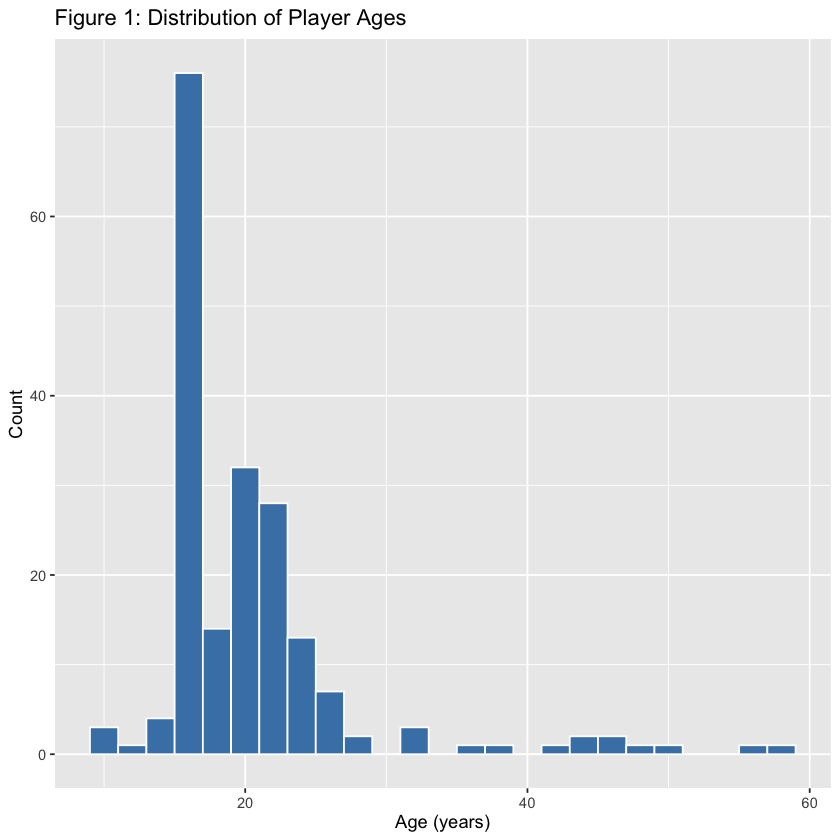

In [23]:
ggplot(players, aes(x = Age)) +
    geom_histogram(binwidth = 2, fill = "steelblue", color = "white") +
    labs(title = "Figure 1: Distribution of Player Ages", x = "Age (years)", y = "Count")

**Figure 1: Distribution of Player Ages.** This histogram shows the age distribution of players in the dataset. The majority of players are young adults, with ages concentrated around 17-25 years old.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


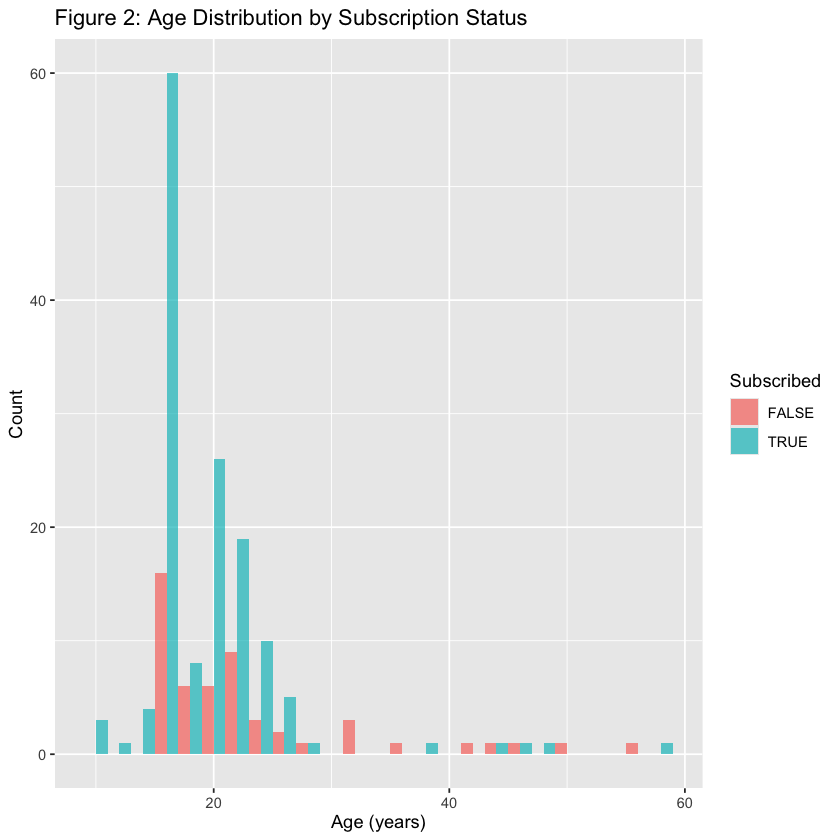

In [24]:
ggplot(players, aes(x = Age, fill = subscribe)) +
    geom_histogram(binwidth = 2, position = "dodge", alpha = 0.7) +
    labs(title = "Figure 2: Age Distribution by Subscription Status",
         x = "Age (years)", y = "Count", fill = "Subscribed")

**Figure 2: Age Distribution by Subscription Status.** This grouped histogram shows how age is distributed between subscribed and non-subscribed players. Both groups have nearly identical age distributions, with most players concentrated in the 17-25 age range, indicating that age shows little correlation with subscription status and is unlikely to be a strong predictor **on its own.**

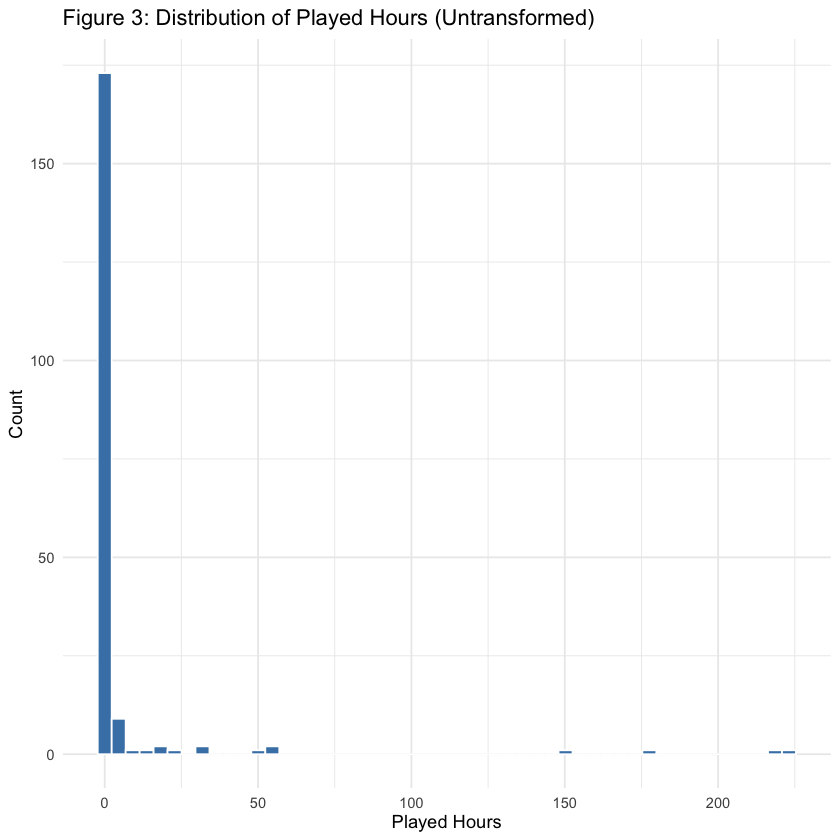

In [25]:
ggplot(players, aes(x = played_hours)) +
    geom_histogram(bins = 50, fill = "steelblue", color = "white") +
    labs(title = "Figure 3: Distribution of Played Hours (Untransformed)",
         x = "Played Hours", y = "Count") +
    theme_minimal()

**Figure 3: Distribution of Played Hours (Untransformed).** This histogram shows the raw distribution of `played_hours`, which is highly right-skewed with the majority of values near zero and a long tail of high values. This extreme skewness motivates the use of a log transformation in Figure 4 to better visualize the relationship with `subscribe`. 

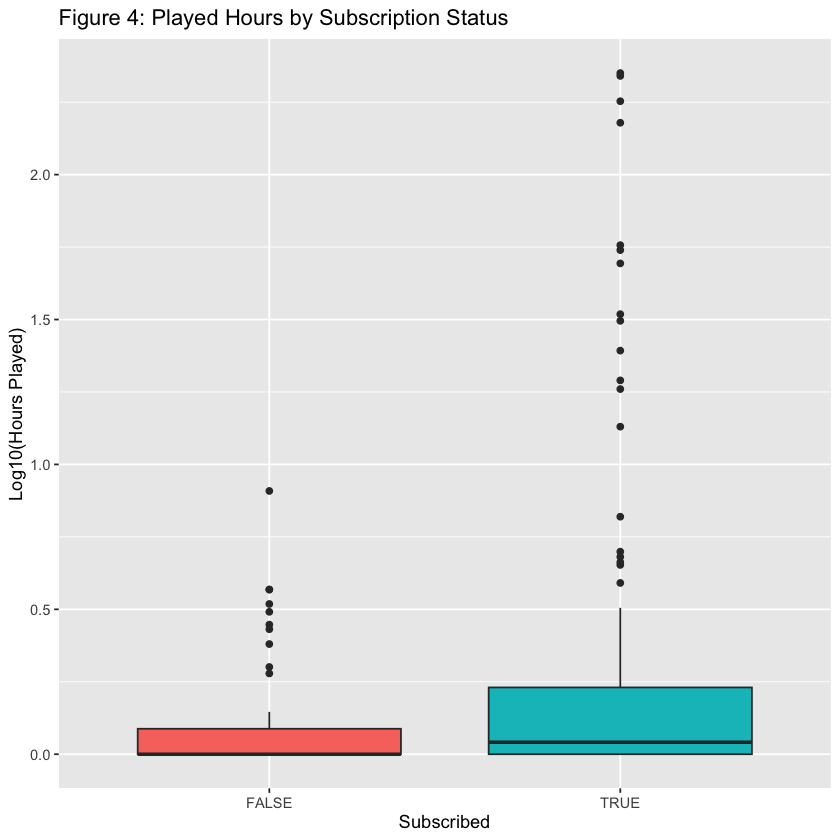

In [26]:
ggplot(players, aes(x = subscribe, y = log10(played_hours + 1), fill = subscribe)) +
    geom_boxplot() +
    labs(title = "Figure 4: Played Hours by Subscription Status", 
         x = "Subscribed", y = "Log10(Hours Played)") +
    theme(legend.position = "none")

**Figure 4: Played Hours by Subscription Status.** Subscribed players tend to have more hours played, indicating `played_hours` may predict subscription. Log-scaled to account for skewness.

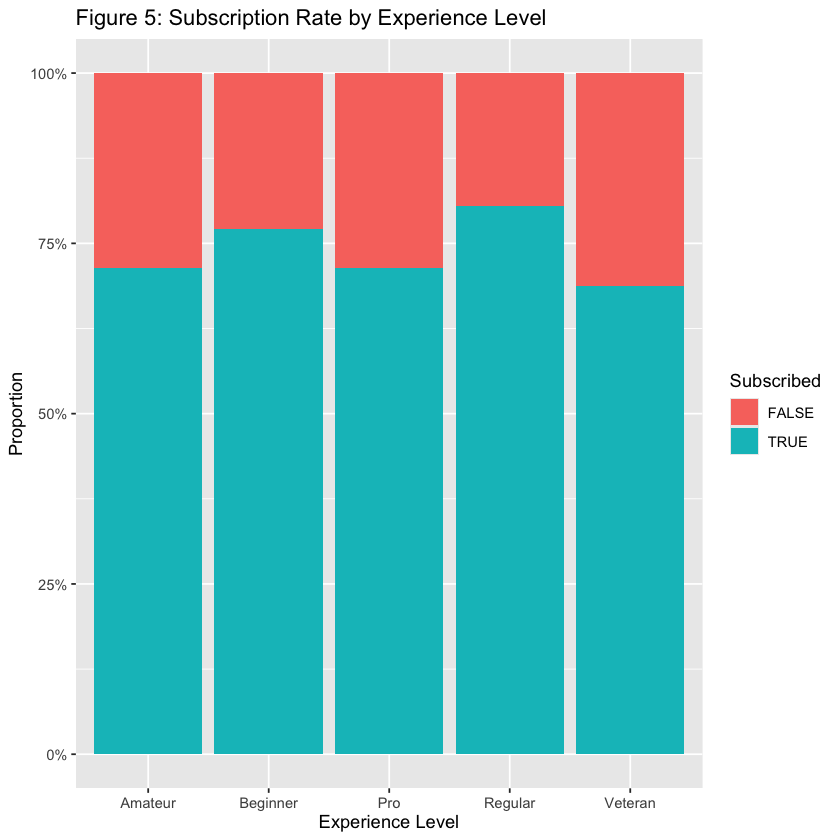

In [27]:
ggplot(players, aes(x = experience, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(title = "Figure 5: Subscription Rate by Experience Level",
         x = "Experience Level", y = "Proportion", fill = "Subscribed") +
    scale_y_continuous(labels = scales::percent)

**Figure 5: Subscription Rate by Experience Level.** This stacked bar chart shows the proportion of subscribed vs non-subscribed players across different experience levels. The subscription rates appear relatively consistent across all experience levels, indicating that `experience` is not a strong predictor of subscription.

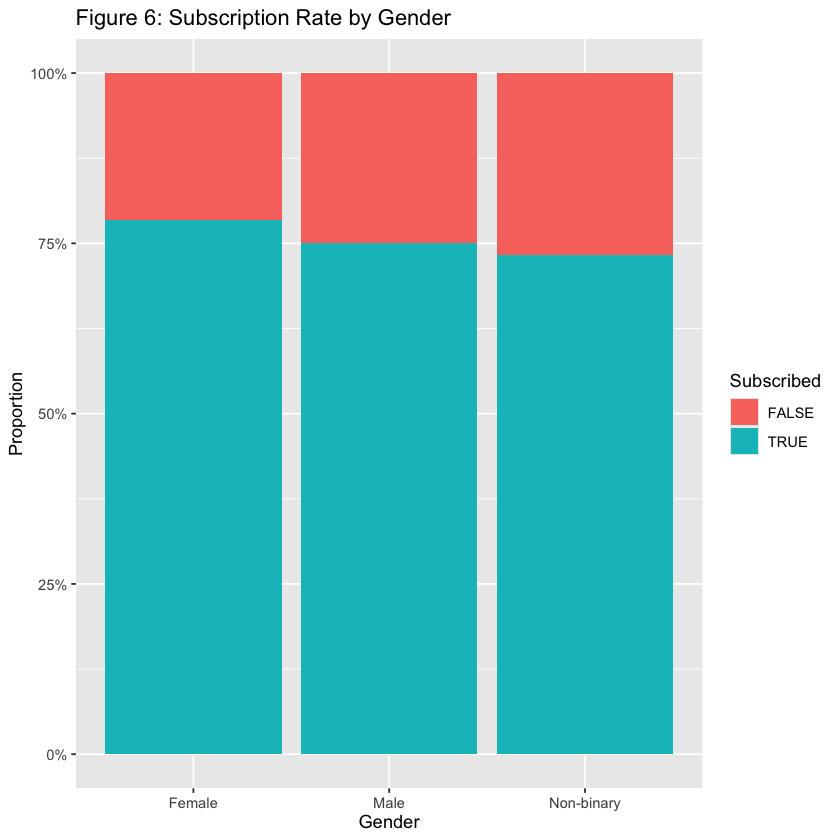

In [28]:
players |>
    group_by(gender) |>
    filter(n() >= 15) |>
    ungroup() |>
    ggplot(aes(x = gender, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(title = "Figure 6: Subscription Rate by Gender",
         x = "Gender", y = "Proportion", fill = "Subscribed") +
    scale_y_continuous(labels = scales::percent)

**Figure 6: Subscription Rate by Gender.** This stacked bar chart shows the proportion of subscribed vs non-subscribed players across gender categories with at least 15 observations. The subscription rates appear relatively consistent across the major gender groups, indicating that `gender` has little effect on subscription and is not a strong predictor. Small categories (e.g., Agender, Prefer not to say, Two-Spirited, Other) were excluded to avoid unreliable proportions based on a small sample size.

**Key Observations from Exploratory Data Analysis:**
- `Age` is mostly around 20 years old, with similar distributions for both subscribers and non-subscribers (Figures 1-2)
- `Age` alone shows little correlation with subscription status and may have limited predictive power individually (Figure 2)
- `played_hours` is highly skewed with many near-zero values (Figure 3), which motivates using log transformation in Figure 4
- Subscribed players tend to have more hours played, indicating `played_hours` may be a stronger predictor of subscription (Figure 4)
- Subscription rates are consistent across `experience` levels, therefore will not be used as a predictor (Figure 5)
- `gender` has little effect on subscription and will not be used as a predictor (Figure 6)
- While individual predictors show varying relationships, K-NN may find useful patterns by combining `Age` and `played_hours` together

### Data Analysis: K-Nearest Neighbors Classification

We use K-NN to predict `subscribe` using `Age` and `played_hours`. K-NN suits binary classification and doesn't assume a specific relationship between predictors and outcome. Predictors must be standardized since K-NN is distance-based.

#### Train/Test Split

In [29]:
set.seed(999) # important for reproducibility
players_split <- initial_split(players_cleaned, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#### Recipe and Model Specification

In [30]:
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |> 
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#### Cross-Validation to Find Optimal k

In [31]:
# use install.packages('kknn') if needed
# install.packages('kknn')
set.seed(999) # for reproducible cross-validation folds
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

k_grid <- tibble(neighbors = seq(1, 50, by = 2))

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |> 
    tune_grid(resamples = players_vfold, grid = k_grid) |> 
    collect_metrics()

accuracies <- knn_results |> 
    filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5579146,5,0.03734379,pre0_mod01_post0
3,accuracy,binary,0.5857635,5,0.02812333,pre0_mod02_post0
5,accuracy,binary,0.6133826,5,0.01484681,pre0_mod03_post0
7,accuracy,binary,0.6414450,5,0.01678050,pre0_mod04_post0
9,accuracy,binary,0.6347783,5,0.01879012,pre0_mod05_post0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
41,accuracy,binary,0.7311494,5,0.005037841,pre0_mod21_post0
43,accuracy,binary,0.7311494,5,0.005037841,pre0_mod22_post0
45,accuracy,binary,0.7311494,5,0.005037841,pre0_mod23_post0


We can visualize the graph of accuracy vs neighbors to get a general idea of how our model is performing with different values of k. 

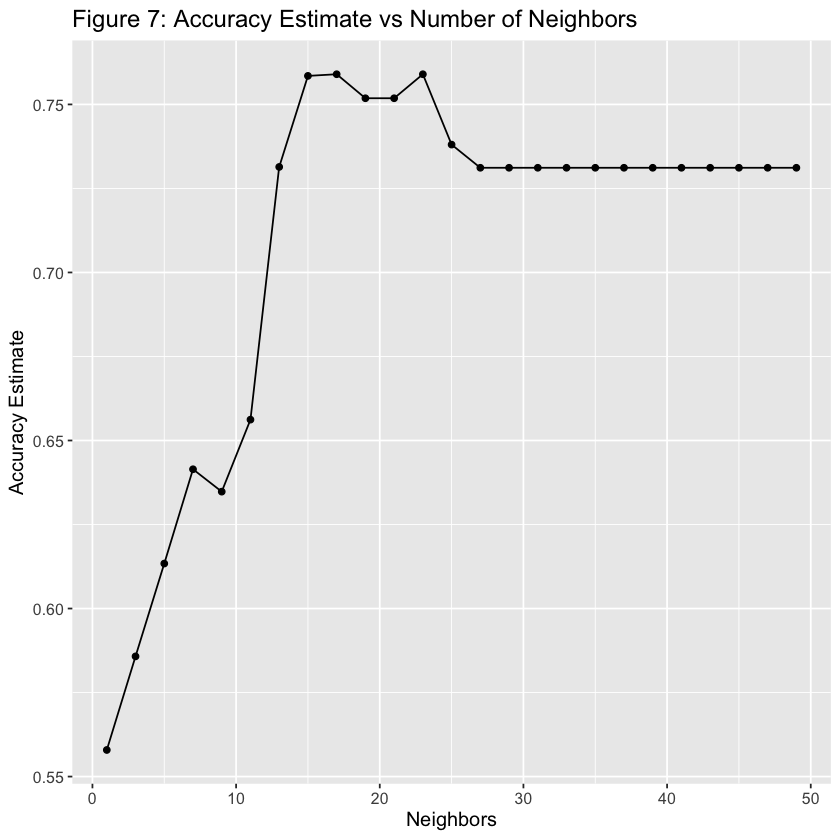

In [32]:

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Figure 7: Accuracy Estimate vs Number of Neighbors",
       x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

**Figure 7: Accuracy Estimate vs Number of Neighbors.**

We can find the K value that maximizes accuracy by taking the value of ```neighbors``` in the ```accuracies``` tibble where the ```mean``` variable is highest.

In [33]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k

[1] 17

From Figure 7, we observe that accuracy peaks at K = 17, where the curve reaches its maximum. The graph shows sharp declines in accuracy below K = 19, and higher K values showing slight fluctuations before dipping down to a consistent average. This indicates K = 17 achieves the best accuracy for our dataset.

#### Final Model and Evaluation

In [34]:
# Full workflow and prediction + evaluation on the test set

players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

players_test_predictions <- knn_fit |>
    predict(players_test) |>
    bind_cols(players_test)

players_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |> 
    filter(.metric == 'accuracy')

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6734694


In [35]:
precision <- players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")
recall <- players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")

precision
recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7272727


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.8888889


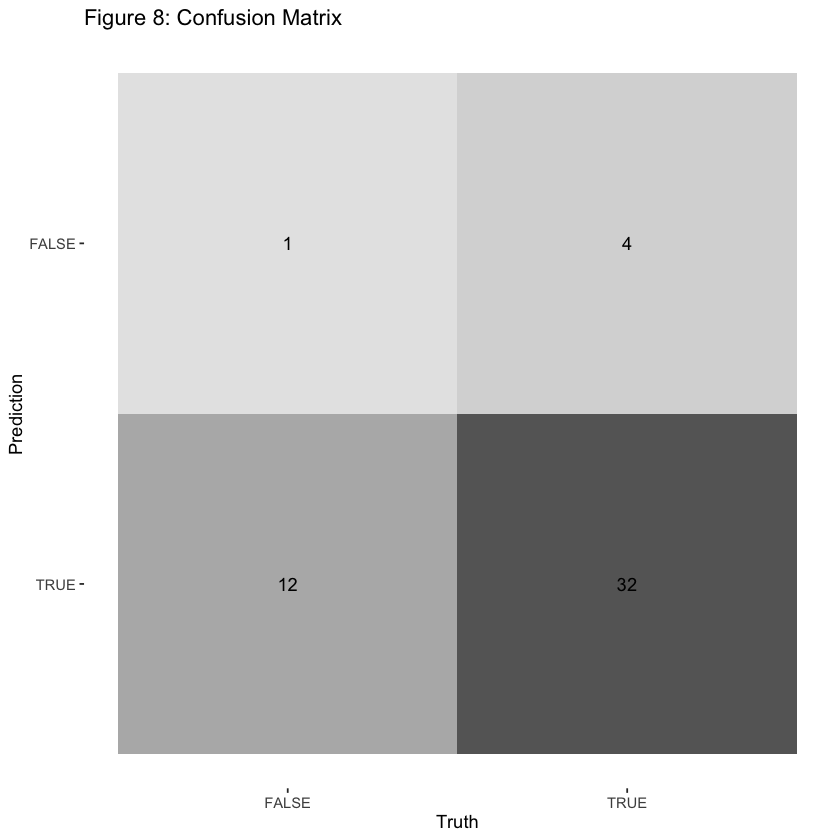

In [36]:
players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class) |>
    autoplot(type = "heatmap") +
    labs(title = "Figure 8: Confusion Matrix")

**Figure 8: Confusion Matrix.** Shows correct predictions (diagonal) vs misclassifications for subscriber prediction.

Our K-NN model achieved a test accuracy of approximately 67.3%, a precision of 71.7% and a recall of 91.7%, meaning there is room for improvement. This suggests that `Age` and `played_hours` together provide some predictive power for `subscribe`, though other unmeasured factors likely influence subscription decisions. The model's performance reflects the weak individual correlations observed in our exploratory analysis, particularly for `Age`.

## Discussion

### Summary of Findings

Our K-Nearest Neighbors classification model successfully predicted newsletter subscription using `Age` and `played_hours` as predictors, achieving a test accuracy of 67.3%, a precision of 71.7% and a recall of 91.7% with K = 17 neighbors. Through exploratory data analysis, we identified that `played_hours` showed a stronger relationship with subscription status than `Age`, with subscribers tending to have higher playtime. The model's moderate accuracy suggests that while these two predictors provide useful information, subscription behavior is influenced by additional factors not captured in our dataset.

### Expected vs. Actual Results

Our initial hypothesis that `played_hours` would be a strong predictor was partially confirmed: subscribed players do tend to have more hours played (Figure 4). Despite the fact that `Age` showed little individual correlation with subscription (Figure 2) -- both subscriber and non-subscriber groups have similar age distributions concentrated around 17-25 years old -- our model being able to combine both predictors achieved better results than either variable alone might have achieved, demonstrating the value of multivariate approaches even with weak individual predictors. However, the test accuracy of 67.3% was less than ideal, indicating that playtime and age doesn't fully explain subscription decisions.

### Impact

This model provides actionable insights for game developers and marketing teams. With 67.3% accuracy, the model can help identify potential subscribers better than random targeting, improving the efficiency of newsletter campaigns. Game developers / server owners could use this model to:
- Prioritize marketing efforts toward players with higher playtime, as they show higher rates of subscription
- Recognize that `age` is not a reliable factor for newsletter targeting within this player demographic

The finding that `experience` level and `gender` have little effect on subscription (Figures 5-6) also suggests that newsletter appeal is relatively universal across these player characteristics, allowing for more inclusive marketing strategies.

### Limitations

Several limitations affect our analysis and model performance:
- **Small dataset:** With only 196 observations (144 subscribers, 52 non-subscribers), the model may not generalize well to larger or different player populations. The class imbalance could bias predictions toward the majority class.
- **Limited predictors:** Using only 2 predictors (`Age` and `played_hours`) restricts model complexity. Many potentially relevant variables such as player engagement patterns, game genre preferences, social connections, or previous newsletter interactions were not available.
- **Data quality issues:** `played_hours` is highly right-skewed with many near-zero values, which may reduce its predictive power despite log transformations for visualization. Two missing `Age` values were removed, potentially introducing bias.
- **Algorithm sensitivity:** K-NN is distance-based and sensitive to outliers, which could affect predictions for players with unusual age or playtime values.
- **Low Efficiency:** Since 93.9% of players are predicted as potential subscribers, this model does not really save much time.

### Future Directions

The research team at PLAICraft could improve model performance and insights through:
- **Additional features:** Introducing variables like in-game achievements, social activity, purchase history, or time since last login could be more insightful than just playtime alone
- **Larger dataset:** Collecting more observations would improve model generalization and allow for more complex modeling approaches
- **Temporal analysis:** Tracking how player behavior evolves over time could reveal patterns in subscription decisions, such as whether recent activity spikes predict subscriptions
- **Feature engineering:** Creating derived features like "playtime per week since signup" or "activity consistency" might be more predictive than total hours alone

## References

Timbers, T., Campbell, T., & Lee, M. (2022). *Data Science: A First Introduction*. Chapter 5: Classification I: Training & Predicting. http://datasciencebook.ca/classification1.html

Timbers, T., Campbell, T., & Lee, M. (2022). *Data Science: A First Introduction*. Chapter 6: Classification II: Evaluation & Tuning. http://datasciencebook.ca/classification2.html